In [168]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
from wordcloud import WordCloud, STOPWORDS 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from sklearn.model_selection import train_test_split

## Make dataframes

In [169]:
jeopardy = pd.read_csv('../data/master_season1-35.tsv', sep = "\t")
regular_tournament = jeopardy[jeopardy['notes']=='-']
special_tournament = jeopardy.drop(regular_tournament.index)

In [170]:
def get_sub_df(df, testsize = .2, sub_fraction = 0.01, state = 123):
    training, testing = train_test_split(df, test_size = testsize, random_state = state)
    sub_training = training.sample(frac = sub_fraction, axis = 0, random_state = state)
    return training, testing, sub_training


jeopardy_train, jeopardy_test, jeopardy_subtrain = get_sub_df(jeopardy)
regular_train, regular_test, regular_subtrain = get_sub_df(regular_tournament)
special_train, special_test, special_subtrain = get_sub_df(special_tournament)

## Clean the text step-by-step
- remove punctuation
- remove stopwords
- lowercase 
- tokenize 
- lemmatiz

In [193]:
# Clean the text individually
def make_text(df, col):
    return df[col]

def lowercase(text):
    return ' '.join(text).lower()

def tokenize(text):
#     text = lowercase(df, col)
    tokenized = [word_tokenize(content) for content in text]
    return tokenized

#TODO: fix up this function 
def remove_punc(df, col):
    """
    removes punctuation from a column of text
    Args:
        df (Pandas dataFrame): The dataframe in use
        col (str): the column name to turn into a string
    Returns:
        [type]: [description]
    """        
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in ' '.join(tokenize(df, col))]
    return stripped

def remove_stopwords(text):
#     docs = tokenize(df, col)
#     text = lowercase(df, col)
    stopwords_set = set(stopwords.words('english'))
    return [[word for word in text if word not in stopwords_set] for word in text]

text = make_text(regular_subtrain, 'category')
text = stringify(text)
text = remove_stopwords(text)


KeyboardInterrupt: 

## clean_columns + wordclouds without stemming and lemmatizing

In [162]:
def clean_columns(df, col):
    '''
    using a pre-made function 
    returns a list of the tokenized and stripped of stopwords 
    '''
    text = stringify(df, col)
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    

    words = [word for word in stripped if word.isalpha()]
    

    # filter out stop words
    if col == 'notes':
        #TODO: add another set of stopwords for the notes
        remove_words = {'final', 'quarterfinal', 'game', 'jeopardy!', 'semifinal', 'round', 'tournament', 'week', 'reunion', 'ultimate', 'night', 'jeopardy', 'night', 'games'}
        stopwords_set = (set(stopwords.words('english'))).union(remove_words)
    else:
        stopwords_set = set(stopwords.words('english'))
    words = [w for w in words if not w in stopwords_set]
    return words

# categories = clean_columns(regular_subtrain, 'category', None)
# ' '.join(categories)

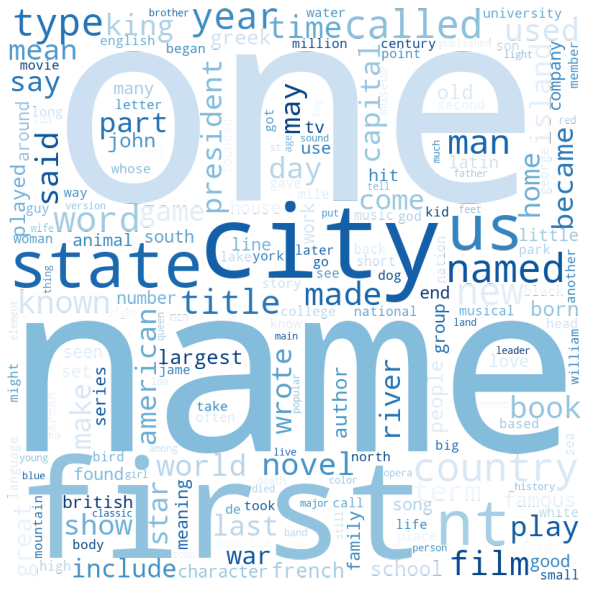

In [163]:
import matplotlib.pyplot as plt

def make_word_cloud(df, col, color, save = False):

    #generate word list
    word_lst = clean_columns(df, col)
    words = ' '.join(word_lst)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color =None, mode = 'RGBA', 
                colormap = color,
                collocations=False,
                min_font_size = 10).generate(words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    if save:
        plt.savefig(f'../images/{df}_{col}_wordcloud.png')
    else:
        plt.show()
    

# make_word_cloud(regular_subtrain, 'category', color = 'cividis_r')
# make_word_cloud(sub_train, 'question', 'Reds')
# make_word_cloud(sub_train, 'answer', 'Blues_r')

## clean_columns + wordclouds WITH stemming and lemmatizing

In [164]:
def clean_columns(df, col, stem = None):
    """
        cleans the columns by converting to a string, 
    lowercasing, removing stopwords, and tokenizing all in one 

    Args:
        df (pandas DataFrame): the DataFrame whose columns 
                will be turned to one string
        col (string): The column name in question
        stem (string), (optional):
                "snowball" for snowball stemmer
                "porter" for porter stemmer. 
                Defaults to None.

    Returns:
        list: a list of words as strings
    """
    text = stringify(df, col)
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # lemmatize the words 
    wordnet = WordNetLemmatizer()
    lemmatized = [wordnet.lemmatize(word) for word in stripped]
    
    #stem words, depending on the stemmer chosen as a parameter
    if stem == 'snowball':
        snowball = SnowballStemmer('english')
        stemmed = [snowball.stem(word) for word in lemmatized]
        # remove remaining tokens that are not alphabetic from stemmed
        words = [word for word in stemmed if word.isalpha()]
    elif stem == 'porter':
        porter = PorterStemmer()
        stemmed = [porter.stem(word) for word in lemmatized]
        # remove remaining tokens that are not alphabetic from stemmed
        words = [word for word in stemmed if word.isalpha()]
    elif stem == None:
        pass
        #skip stemming
        # remove remaining tokens that are not alphabetic from lemmatized
    else:
        words = [word for word in lemmatized if word.isalpha()]
    
    # filter out stop words
    if col == 'notes':
        #TODO: add another set of stopwords for the notes
        remove_words = {'final', 'quarterfinal', 'game', 'jeopardy!', 'semifinal', 'round', 'tournament', 'week', 'reunion', 'ultimate', 'night', 'jeopardy', 'night', 'games'}
        stopwords_set = (set(stopwords.words('english'))).union(remove_words)
    else:
        stopwords_set = set(stopwords.words('english'))
    words = [w for w in words if not w in stopwords_set]
    return words

In [165]:
def make_word_cloud(df, col, color, stem = None, save = False):
    """makes a word cloud of the words per column

    Args:
        df (pandas DataFrame): the DataFrame whose columns 
                will be turned to one string
        col (string): the string in question 
        color (string): the colormap preset to use
        save (bool, optional): Whether to save the figure or just show
                will save the figure as a .png, False will show the figure
                Defaults to False.
    """    
    #generate word list
    word_lst = clean_columns(df, col, stem = None) # can also get the words from the text vectorizer above
    words = ' '.join(word_lst)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color =None, mode = 'RGBA', 
                colormap = color,
                collocations=False,
                min_font_size = 10).generate(words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    if save:
        plt.savefig(f'../images/{col}_wordcloud.png')
    else:
        plt.show()
        
# make_word_cloud(jeopardy, 'category', stem = None, color = 'plasma', save = True)
# make_word_cloud(jeopardy, 'question', stem = None, color = 'Blues_r', save = True)
# make_word_cloud(jeopardy_subtrain, 'answer', stem = None, color = 'cividis_r', save = True)

## Make a vectorizer

In [171]:
count_vect = CountVectorizer(ngram_range = (1, 2), 
                            lowercase=True, tokenizer=None, 
                            stop_words='english', analyzer='word',  
                            max_features=None)

In [172]:
count_vect.fit_transform(sub_train['category'])

<11356x8970 sparse matrix of type '<class 'numpy.int64'>'
	with 29685 stored elements in Compressed Sparse Row format>

In [173]:
count_vect.vocabulary_.keys()

dict_keys(['musical', 'terms', 'musical terms', 'studying', 'abroad', 'studying abroad', 'does', 'mom', 'does mom', 'highways', 'byways', 'highways byways', 'young', 'people', 'difference', 'young people', 'people difference', 'lights', 'camera', 'action', 'movie', 'lights camera', 'camera action', 'action movie', 'savants', 'happened', 'europe', 'happened europe', 'quick', 'history', 'quick history', 'feminism', 'americana', 'travel', 'rodin', 'composers', 'ends', 'vowels', 'ends vowels', 'sweet', 'virginia', 'sweet virginia', 'cliche', 'european', 'european history', 'bodies', 'water', 'bodies water', 'rhyme', 'time', 'rhyme time', 'teen', 'potpourri', 'teen potpourri', 'west', 'wing', 'west wing', 'vacation', 'born', 'history born', 'state', 'capitals', 'state capitals', 'stranger', 'things', 'stranger things', 'doesn', 'dirt', 'doesn rhyme', 'rhyme dirt', 'mozart', 'friends', 'mozart friends', 'ex', 'oh', 'ex oh', 'victory', 'silent', 'era', 'silent movie', 'movie era', 'ax', 'word

In [87]:
count_vect.get_feature_names()

['00',
 '10',
 '10 11',
 '10 hut',
 '10 largest',
 '10 letter',
 '10 years',
 '100',
 '100 years',
 '100th',
 '100th birthday',
 '101',
 '1017',
 '11',
 '11 12',
 '11 letter',
 '12',
 '12 letter',
 '12 letters',
 '12 tribes',
 '1200s',
 '13',
 '13 colonies',
 '13 letter',
 '14',
 '14 letter',
 '1480s',
 '14th',
 '14th century',
 '15',
 '15 letter',
 '1500',
 '15th',
 '15th century',
 '15th grader',
 '1600s',
 '1690s',
 '16th',
 '16th century',
 '17',
 '17 letter',
 '1776',
 '1796',
 '17th',
 '17th century',
 '18',
 '1800',
 '1800s',
 '1801',
 '1801 1810',
 '1810',
 '1820s',
 '1830s',
 '1840s',
 '1840s america',
 '1851',
 '1865',
 '1867',
 '1871',
 '1890s',
 '1899',
 '18th',
 '18th century',
 '1900',
 '1900s',
 '1901',
 '1902',
 '1910s',
 '1918',
 '1920s',
 '1940s',
 '1940s television',
 '1950',
 '1950s',
 '1950s song',
 '1950s women',
 '1955',
 '1960s',
 '1960s black',
 '1960s sitcoms',
 '1970',
 '1970s',
 '1970s tv',
 '1973',
 '1976',
 '1979',
 '1980s',
 '1980s books',
 '1980s quick',

set()

- output of vectorizer is the array of the bag of words
- vocabulary attribute gives word mapped to the index 

#### Soft Cluster
- get a TFIDF matrix
- pass the TFIDF as a feature to the NMF 
- when I print whats in a topic, I want to print the 'category' of the question clas associated with the loadings on that 'category'
- identify some outliers


#### Naive Bayes
- Construct a naive bayes on the words

Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'